In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(13)

import tensorflow as tf 
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import neighbors, datasets, tree, linear_model, metrics,svm
from sklearn.model_selection import cross_val_score, train_test_split,KFold
import itertools
from itertools import permutations
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


# 1. Import Data

In [70]:
df=pd.read_csv('spambase.data',header=None)
df.columns=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet',
           'word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses',
           'word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000',
           'word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857',
           'word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs',
           'word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;',
           'char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest',
           'capital_run_length_total','spam']
df['spam']=df['spam'].astype(str)


 # 2. Train-Test Data Split

In [71]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=['spam']),df['spam'],test_size=0.2,random_state=9)

# 3. SMOTE to fix imbalance problem

In [72]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [73]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

# 4. Data Normalization

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler=scaler.fit(x_train)
x_train[x_train.columns] = scaler.transform(x_train[x_train.columns])
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

# 5. Nested Grid Search CV to find the best model, using accuracy

In [75]:
# Create the CV
inner_cv = KFold(n_splits=5, shuffle=True, random_state=9)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=9)

# Create the Classifier
def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, input_dim=57, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)
t=tree.DecisionTreeClassifier(random_state=9)
knn=neighbors.KNeighborsClassifier()
s=svm.SVC(random_state=9)

# Set up the parameter grid
NN_grid = {'activation':['relu', 'sigmoid'], 'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}
tree_grid={'criterion':['gini','entropy'],
           'max_depth':list(range(30))}
knn_grid={'weights':['uniform','distance'],
          'n_neighbors':list(range(5,31))}
svm_grid={'C':[0.1,1,5,10,50,100],
          'gamma':[1,5,10,15,20,25,30,50,100],
          'kernel':['linear','rbf']}

#Nested CV for Neural Network
clf = GridSearchCV(estimator=NN, param_grid=NN_grid, cv=inner_cv,scoring='accuracy')
nested_score = cross_val_score(clf, X=x_train, y=y_train, cv=outer_cv,scoring='accuracy')
NN_result=nested_score.mean()

#Nested CV for SVM
clf = GridSearchCV(estimator=s, param_grid=svm_grid, cv=inner_cv,scoring='accuracy')
nested_score = cross_val_score(clf, X=x_train, y=y_train, cv=outer_cv,scoring='accuracy')
svm_result=nested_score.mean()

#Nested CV for Decision Tree
clf = GridSearchCV(estimator=t, param_grid=tree_grid, cv=inner_cv,scoring='accuracy')
nested_score = cross_val_score(clf, X=x_train, y=y_train, cv=outer_cv,scoring='accuracy')
tree_result=nested_score.mean()

#Nested CV for KNN
clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv,scoring='accuracy')
nested_score = cross_val_score(clf, X=x_train, y=y_train, cv=outer_cv,scoring='accuracy')
knn_result=nested_score.mean()

print('Average Performance of Neural Network Classifier: {}%'.format(round(NN_result*100,2)))
print('Average Performance of SVM Classifier: {}%'.format(round(svm_result*100,2)))
print('Average Performance of Decision Tree Classifier: {}%'.format(round(tree_result*100,2)))
print('Average Performance of KNN Classifier: {}%'.format(round(knn_result*100,2)))

Average Performance of Neural Network Classifier: 94.64%
Average Performance of SVM Classifier: 94.08%
Average Performance of Decision Tree Classifier: 93.14%
Average Performance of KNN Classifier: 91.94%


# 6-1. Use GridSearch to find best hyper-parameters for 4-layers NN model

In [77]:
#Grid Search Verison
NN_grid = {'activation':['relu', 'sigmoid'], 'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}
# Create the Classifier
def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, input_dim=57, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)

#Grid Search CV for Neural Network
NNmodel = GridSearchCV(estimator=NN, param_grid=NN_grid, cv=5,scoring='accuracy')
NNmodel.fit(x_train, y_train)

#Result
print('The best parameters activation={} & nb_hidden={}'.format(NNmodel.best_params_['activation'],NNmodel.best_params_['nb_hidden']))
print("Prediction Accuracy Score on Test Data: {}%".format(round(metrics.accuracy_score(y_test, NNmodel.predict(x_test))*100,2)))
print("Recall positive on Test Data: {}%".format(round(metrics.recall_score(y_test, NNmodel.predict(x_test),pos_label=1)*100,2)))

The best parameters activation=relu & nb_hidden=100
Prediction Accuracy Score on Test Data: 94.46%
Recall positive on Test Data: 93.8%


# 6-2. Use RandomSearch to find best hyper-parameters for 4-layers NN model

In [78]:
#Random Search Version
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=10,
                                        max_value=100,
                                        step=10),
                           activation='relu',input_dim=57))
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=10,
                                        max_value=100,
                                        step=10),
                           activation='relu'))
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=10,
                                        max_value=100,
                                        step=10),
                           activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[0.01,0.001,0.0001])),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

tuner=RandomSearch(build_model,
                   objective='accuracy',
                   max_trials=5,
                   overwrite=True,
                   seed=99,
                   executions_per_trial=5)

#Keras cannot input object data type, so no matter the column is boolean or numeric we need to transform them to float32
x_train_float = np.asarray(x_train).astype(np.float32)
y_train_float = np.asarray(y_train).astype(np.float32)
x_test_float = np.asarray(x_test).astype(np.float32)
y_test_float = np.asarray(y_test).astype(np.float32)

tuner.search(x=x_train_float,y=y_train_float,epochs=30,batch_size=512,validation_data=(x_test_float,y_test_float))

Trial 5 Complete [00h 00m 08s]
accuracy: 0.9723672270774841

Best accuracy So Far: 0.9880287885665894
Total elapsed time: 00h 00m 42s
INFO:tensorflow:Oracle triggered exit


In [79]:
#Get the best model
NNmodel2=tuner.get_best_models()[0]

In [80]:
#result
result=tuner.get_best_hyperparameters()[0].values
print('The best 4-layers NN parameters would be {} neurons and {} learning rate.'.format(result['units'],result['learning_rate']))
print('------------------------------------------')
print("The best model's accuracy on test data = 98%")
print('------------------------------------------')
print(tuner.results_summary())

The best 4-layers NN parameters would be 100 neurons and 0.01 learning rate.
------------------------------------------
The best model's accuracy on test data = 98%
------------------------------------------
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
Score: 0.9880287885665894
Trial summary
Hyperparameters:
units: 60
learning_rate: 0.01
Score: 0.9828082680702209
Trial summary
Hyperparameters:
units: 50
learning_rate: 0.01
Score: 0.9807830810546875
Trial summary
Hyperparameters:
units: 30
learning_rate: 0.01
Score: 0.9723672270774841
Trial summary
Hyperparameters:
units: 90
learning_rate: 0.0001
Score: 0.8956345677375793
None


# 7. Plot the ROC Curve & Confusion Matrix

In [81]:
prob=NNmodel2.predict(x_test)
tem=[]
for i in range(len(prob)):
    tem.append(prob[i][0])
prob=tem
y_pred=[]
for i in range(len(prob)):
    if prob[i]>0.5:
        y_pred.append('1')
    else:
        y_pred.append('0')


True       0    1
Predict          
0        542   23
1         24  332


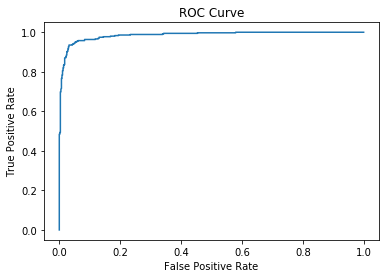

In [83]:
#create the confucion matrix
tem=pd.DataFrame({'True':y_test,'Predict':y_pred})
print(tem.groupby(['Predict','True']).size().unstack())

#create ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, prob,pos_label=1)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

#### According to the Lift Curve, I find the SVM model is really good at capturing spam cases. In addition according to the confustion matrix and cost structure, the average misclassification rate = (230+24) / 921 = 0.2757

# 10. According to the cost model, the consequence of mis-classifying positive cases are more severe. The weight for class 1 is 10, and the weight for class 0 is 1. Hence, this time I try to find the best 4-layers NN model with different class weights.

In [84]:
#Grid Search Verison
NN_grid = {'activation':['relu', 'sigmoid'], 'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}
# Create the Classifier
def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, input_dim=57, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)

#Grid Search CV for Neural Network
NNmodel3 = GridSearchCV(estimator=NN, param_grid=NN_grid, cv=5,scoring='accuracy')
class_weight = {0: 1.,1:10.}
NNmodel3.fit(x_train, y_train,class_weight=class_weight)

#Result
print('The best parameters activation={} & nb_hidden={}'.format(NNmodel3.best_params_['activation'],NNmodel3.best_params_['nb_hidden']))
print("Prediction Accuracy Score on Test Data: {}%".format(round(metrics.accuracy_score(y_test, NNmodel3.predict(x_test))*100,2)))
print("Recall positive on Test Data: {}%".format(round(metrics.recall_score(y_test, NNmodel3.predict(x_test),pos_label=1)*100,2)))

The best parameters activation=relu & nb_hidden=100
Prediction Accuracy Score on Test Data: 92.94%
Recall positive on Test Data: 95.77%


In [85]:
#create the confucion matrix
y_pred=NNmodel3.predict(x_test)
y_pred=[ y_pred[i][0] for i in range(len(x_test))]
tem=pd.DataFrame({'True':y_test,'Predict':y_pred})
print(tem.groupby(['Predict','True']).size().unstack())

True       0    1
Predict          
0        516   15
1         50  340


#### According to the confustion matrix, after taking class wights into account, the average misclassification rate drop dramatically to (150+50) / 921 = 0.217.